Philippe Joly MAIS 202

This is an implementation of a Sequential Convolutional Neural Network (CNN) to predict Electrical Power Demand based on the Weather in Quebec. The strategy being to create a tensor of sequential data (as would be done for a LSTM) and train a CNN on it.

In [32]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt
import os
from dotenv import load_dotenv
load_dotenv()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DATA

In [33]:
data = pd.read_csv(os.getenv("DATA"))
data['Date/Time (UTC)'] = pd.to_datetime(data['Date/Time (UTC)'])

day = 60*60*24
year = 365.2425*day
week = 7*day
data['Seconds'] = data['Date/Time (UTC)'].map(pd.Timestamp.timestamp)
data['Day sin'] = np.sin(data['Seconds'] * (2* np.pi / day))
data['Day cos'] = np.cos(data['Seconds'] * (2 * np.pi / day))
data['week sin'] = np.sin(data['Seconds'] * (2 * np.pi / week))
data['week cos'] = np.cos(data['Seconds'] * (2 * np.pi / week))
data['Year sin'] = np.sin(data['Seconds'] * (2 * np.pi / year))
data['Year cos'] = np.cos(data['Seconds'] * (2 * np.pi / year))

data.drop(columns=['Year','Month','Day','Hour','Day of Week','Population', 'Seconds'], inplace=True)
data.set_index('Date/Time (UTC)', inplace=True)

column_order = ['Average Power Output (MW)'] + [col for col in data.columns if col != 'Average Power Output (MW)']
data = data[column_order]

# MODEL

In [34]:
class SCNN(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(SCNN, self).__init__()
        self.to(device)
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device) 
        
        out, _ = self.rnn(X, h0)
        out = out[:,-1,:]
        out = self.output_layer(out)
        return out
    
    def getScale(self,X):
        self.means = []
        self.stds = []

        for i in range(self.input_size):
            self.means.append(np.mean(X[:,:,i]))
            self.stds.append(np.std(X[:,:,i]))

    def scaleX(self, X):
        for i in range(self.input_size):
            X[:,:,i] = (X[:,:,i]-self.means[i])/self.stds[i]
        return X
    
    def scaley(self, y):
        y = (y-self.means[0])/self.stds[0]
        return y
    
    def unscaley(self,y):
        y = y*self.stds[0]+self.means[0]
        return y
    
    def df_to_Xy(df, window_size):
        dfArr = df.to_numpy()
        X = []
        y= []
        for i in range(len(dfArr)-window_size):
            row = [r for r in dfArr[i:i+window_size]]

            if (np.isnan(row).any() or np.isnan(dfArr[i+window_size][0])):
                continue

            X.append(row)
            label = dfArr[i+window_size][0]
            y.append(label)
        return np.array(X), np.array(y)
    
    def data_split(df, train_perc=90, test_perc=5, window_size=6):
        X_tot, y_tot = RNN.df_to_Xy(data, window_size)
        
        size = X_tot.shape[0]
        size_train = (size*train_perc)//100
        size_test = (size*test_perc)//100
        size_val = size-size_train-size_test
        
        X, y = X_tot[:size_train], y_tot[:size_train]
        X_val, y_val = X_tot[size_train:size_train+size_val], y_tot[size_train:size_train+size_val]
        X_test, y_test = X_tot[size_train+size_val:], y_tot[size_train+size_val:]

        return X, X_val, X_test, y, y_val, y_test
    
    def fit(self, X_train, y_train, X_val, y_val, num_epochs, batch_num, lr):
        batch_size = X_train.shape[0]//batch_num
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        self.train_losses = []
        self.val_losses = []
        self.it_ls = []

        self.getScale(X_train)
        X_train = torch.from_numpy(self.scaleX(X_train))
        y_train = torch.from_numpy(self.scaley(y_train))

        X_val = torch.from_numpy(self.scaleX(X_val)).to(torch.float32).to(device)
        y_val = torch.from_numpy(self.scaley(y_val)).to(torch.float32).to(device)

        train_load = torch.utils.data.TensorDataset(X_train,y_train)
        train_load = torch.utils.data.DataLoader(dataset=train_load, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            for i, (X, y) in enumerate(train_load):
                self.it_ls.append(epoch*len(train_load)+i)
                X= X.to(torch.float32).to(device)
                y = y.to(torch.float32).to(device)
                
                outputs = self.forward(X)
                outputs = outputs.reshape(outputs.shape[0])

                loss = criterion(outputs, y)
                self.train_losses.append(loss.item())

                with torch.no_grad():
                    val_outputs=self.forward(X_val)
                    self.val_losses.append(criterion(val_outputs.reshape(val_outputs.shape[0]), y_val).item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if((epoch*len(train_load)+i+1)%(num_epochs*len(train_load)//10+1)==0):
                    print(f'epoch: {epoch+1}/{num_epochs}, step {i+1}/{len(train_load)}, loss = {loss.item():.4f}')
    
    def train_score(self):
        print(f'Training Loss: {self.train_losses[-1]:.4f}')
        print(f'Validation Loss: {self.val_losses[-1]:.4f}')

        plt.plot(self.it_ls, self.train_losses, color="blue", label="Training Loss")
        plt.plot(self.it_ls, self.val_losses, color="red", label="Validation Loss")
        plt.xlabel("Iterations")
        plt.ylabel("MSE")
        plt.title("Training and Validation MSE")
        plt.legend()
        plt.show()

    def test_score(self, X_test, y_test, scaled=False):
        with torch.no_grad():
            if(not scaled):
                X_test = self.scaleX(X_test)
            outputs = self.forward(torch.from_numpy(X_test).to(torch.float32).to(device)).to('cpu').detach().numpy()
            y_pred = self.unscaley(outputs)

            print(f'MSE: {mean_squared_error(y_test, y_pred)}')
            print(f'R2: {r2_score(y_test, y_pred)}')
            print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

            return y_pred

    def save_model(self, name):
        time = dt.now().strftime("%y-%m-%d_%H:%M")
        f = f"../trainedModels/{name}_{time}.pth"
        torch.save(self.state_dict(), f)

# Training and Testing

In [35]:
X, X_val, X_test, y, y_val, y_test = SCNN.data_split(df=data, train_perc=90, test_perc=5, window_size=6)

model = SCNN(input_size=X.shape[2], output_size=1, num_layers=2, hidden_size=48)

In [36]:
model.fit(X_train=X, y_train=y, X_val=X_val, y_val=y_val, num_epochs=50, batch_num=1, lr=0.001)

epoch: 6/50, step 1/1, loss = 0.4349
epoch: 12/50, step 1/1, loss = 0.1569
epoch: 18/50, step 1/1, loss = 0.1340
epoch: 24/50, step 1/1, loss = 0.1172
epoch: 30/50, step 1/1, loss = 0.0898
epoch: 36/50, step 1/1, loss = 0.0771
epoch: 42/50, step 1/1, loss = 0.0613
epoch: 48/50, step 1/1, loss = 0.0548


Training Loss: 0.0507
Validation Loss: 0.0257


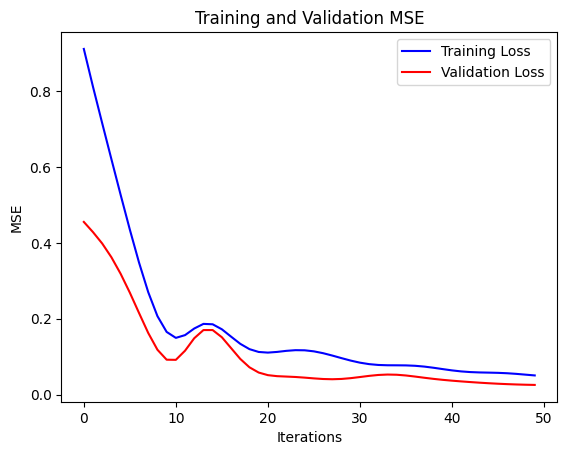

MSE: 38015110.040001154
R2: -11.822422115986386
MAE: 5978.945764075007


In [37]:
model.train_score()
y_pred = model.test_score(X_test=X_val, y_test=y_val, scaled=True)

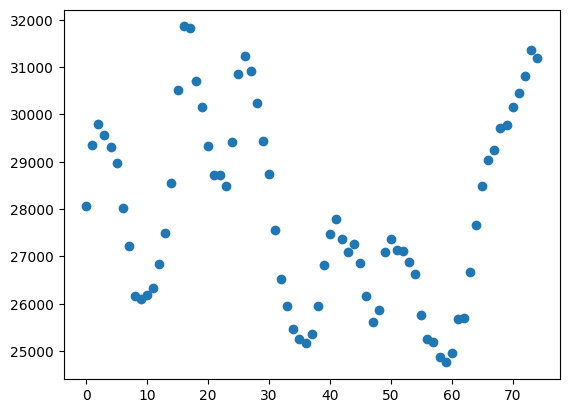

In [43]:
s=1500
l =75
ind = np.zeros(l)
for i in range(l):
    ind[i] = i
plt.scatter(ind, y_pred[s:s+l],color="red")
plt.scatter(ind, y_test[s:s+l])

In [40]:
#model.save_model(f"../trainedModels/rnn_1x128hid")